### Notebook for constructiong POD-NODE NIROM approximation for a flow around a cylinder example

A collection of high-fidelity snapshots are generated that sufficiently capture the time-dynamics of the simulation. POD is adopted to define a reduced basis space for the high-fidelity snaphosts. The evolution of the time dynamics in the POD-latent space is modeled using Neural ODEs (NODE).  

OpenFOAM is used as the high-fidelity model for simulating flow around a cylinder governed by incompressible 2D Navier Stokes.  

In [1]:
### Loading modules
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import scipy
import os
import gc
import argparse
import platform
print("Python "+str(platform.python_version()))
import importlib
from importlib import reload as reload

import tensorflow as tf
print("Tensorflow "+ str(tf.__version__))
if tf.__version__ == '1.15.0':
    tf.compat.v1.enable_eager_execution()
elif tf.__version__.split('.')[0] == 2: 
    print("Setting Keras backend datatype")
    tf.keras.backend.set_floatx('float64')

from tfdiffeq import odeint,odeint_adjoint
from tfdiffeq.adjoint import odeint as adjoint_odeint
tf.keras.backend.set_floatx('float64')
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
np.random.seed(0)

basedir   = os.getcwd()
srcdir = os.path.join(basedir,'../pynirom/')
workdir   = os.path.join(basedir,'../examples/')
datadir   = os.path.join(basedir,'../data/')
figdir    = os.path.join(basedir,'../figures')
nodedir   = os.path.join(basedir,'../data/')
savedir = nodedir+'cylinder/current'

import pynirom
from pynirom.pod import pod_utils as pod
from pynirom.utils import data_utils as du
from pynirom.node import main as nd
from pynirom.node import plotting as pu
from pynirom.node import node as node



Python 3.8.0
Tensorflow 2.4.1
Num GPUs Available:  0


2021-07-18 04:07:57.072069: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set


In [2]:
device = 'cpu:0'           # select gpu:# or cpu:#
purpose= 'train'           #'train' to train a new model, 
                           # 'retrain' to start training from an existing model, and 
                           # 'eval' to load a pre-trained model for evaluation 
pre_trained_dir = savedir+'/model_weights/' #If 'eval' specify path for pretrained model
stacking = True            #If True, Specify new stacking order of latent space vector
stack_order = 'v_x,v_y,p'  #If stacking = True, specify the stacking order of the latent space vector
scale_time = False         #Scale time or not (Normalize)
scale_states = True        #Scale states or not (MinMax -1,1)
augmented,aug_dims = (False,5) #Augmented or not and size of augmentation
N_layers = int(1)          #Only four layers supported as of now.
N_neurons = int(256)       #Number of neurons per layer
act_f = 'tanh'             #Activation Function ('linear', 'tanh', 'sigmoid',...), default='tanh'
learning_rate_decay = True #Use decaying learning rate or not
initial_learning_rate = float(0.001) #If 'learning_rate_decay = False' then this is the fixed learning rate
decay_steps = int(5001)    #Number of steps for learning rate decay
decay_rate = float(0.5)    #Rate of learning rate decay
staircase_opt = True       #True for staircase decay and False for exponential
optimizer = 'RMSprop'      #Adam and RMSprop optimizers are supported as of now
use_adjoint = False        #Use adjoint method or not
solver = 'rk4'             #Specify ODE solver. See tfdiffeq README for available options 
use_minibatch, batch_size = (False,256) #Use minibatch or not and batch size
epochs = int(10)           #Number of epochs of training


print("\n***** Runtime parameters: ******\n")
print(f'Mode = {purpose}, Scaling = {scale_states}, Augmenting = {augmented}, Adjoint = {use_adjoint}')
print(f'Solver = {solver}, Optimizer = {optimizer}, Stacking order = {stack_order}, Epochs = {epochs}')
print(f'# Layers = {N_layers}, # Neurons per layer = {N_neurons}, Activation fn = {act_f}')
if use_minibatch:
    print(f'Use minibatch = {use_minibatch}, Batch size = {batch_size}')
if learning_rate_decay:
    print(f'Init LR = {initial_learning_rate}, # LR decay steps = {decay_steps}, LR decay rate = {decay_rate}')
else:
    print(f'Fixed LR = {initial_learning_rate}')
print('**********************************\n')




***** Runtime parameters: ******

Mode = retrain, Scaling = True, Augmenting = False, Adjoint = False
Solver = rk4, Optimizer = RMSprop, Stacking order = v_x,v_y,p, Epochs = 10
# Layers = 1, # Neurons per layer = 256, Activation fn = tanh
Use minibatch = True, Batch size = 256
Init LR = 0.001, # LR decay steps = 5001, LR decay rate = 0.5
**********************************



In [3]:
### ------ Import Snapshot data -------------------
data = np.load(datadir + 'cylinder_Re100.0_Nn14605_Nt3001.npz')
mesh = np.load(datadir + 'OF_cylinder_mesh_Nn14605_Ne28624.npz')

print('HFM data has {0} snapshots of dimension {1} for h,u and v, spanning times [{2}, {3}]'.format(
                    data['time'].shape[0],data['p'].shape[0],
                    data['time'][0], data['time'][-1]))


## ------- Prepare training snapshots ----------------
print('\n-------Prepare training and testing data---------')
soln_names = ['p', 'v_x', 'v_y']
nodes = mesh['nodes'];  node_ind = mesh['node_ind']
triangles = mesh['elems']; elem_ind = mesh['elem_ind']
snap_start = 1250
T_end = 5.0        ### 5 seconds
snap_incr = 4

snap_train, times_train = du.prepare_data(data, soln_names, start_skip=1250, T_end=5.0, incr=snap_incr)
print('Using {0} training snapshots for time interval [{1},{2}]'.format(times_train.shape[0],
                                        times_train[0], times_train[-1]))

## ------- Prepare testing snapshots ----------------
pred_incr = snap_incr -3
snap_pred_true, times_predict = du.prepare_data(data, soln_names, start_skip=snap_start, incr=pred_incr)
print('Using {0} testing snapshots for time interval [{1},{2}]'.format(times_predict.shape[0],
                                        times_predict[0], times_predict[-1]))



del data
del mesh
gc.collect()

HFM data has 3001 snapshots of dimension 14605 for h,u and v, spanning times [0.0, 6.0]

-------Prepare training and testing data---------
Using 313 training snapshots for time interval [2.5,4.996]
Using 1750 testing snapshots for time interval [2.5,5.998]


190

In [4]:
### ------ Compute the POD basis using the training snapshots------------------
trunc_lvl = 0.99
snap_norm, snap_mean, U, D, W = pod.compute_pod_multicomponent(snap_train)
nw, U_r = pod.compute_trunc_basis(D, U, eng_cap = trunc_lvl)

### ------ Compute the POD coefficients for training snapshots------------------
Z_train = pod.project_onto_basis(snap_train, U_r, snap_mean)


### ------ Compute the POD coefficients for the truth snapshots on the prediction interval------------------
Z_pred_true = pod.project_onto_basis(snap_pred_true, U_r, snap_mean)

npod_total = 0
for key in soln_names:
    npod_total+=nw[key]

p truncation level for 99.0% = 5, \sigma_6 = 17.58326064444933
v_x truncation level for 99.0% = 8, \sigma_9 = 10.971372231083336
v_y truncation level for 99.0% = 7, \sigma_8 = 13.390899418495513


In [5]:
### ---- Setup NODE input data

reload(nd)
NODE = nd.NODEBase(device=device)
true_state_array, true_pred_state_array, init_state, state_len, dt_train, dt_predict = \
        NODE.prepare_input_data(Z_train, nw, times_train, stack_order, times_predict, Z_pred_true)

print("Training NODE using %d modes for %d time steps with %.3f <= t <= %.3f and dt = %.4f"%(state_len,
                             true_state_array.shape[0], times_train[0], 
                             times_train[-1], dt_train))
print("Predicting NODE solutions using %d modes for %d time steps with %.3f <= t <= %.3f and dt = %.4f"%(
                            state_len, true_pred_state_array.shape[0], times_predict[0], 
                            times_predict[-1], dt_predict))

Training NODE using 20 modes for 313 time steps with 2.500 <= t <= 4.996 and dt = 0.0080
Predicting NODE solutions using 20 modes for 1750 time steps with 2.500 <= t <= 5.998 and dt = 0.0020


In [6]:
### Preprocess training data (scale time and/or states, augment states if using ANODE)
### Set up learning rate scheduler and optimizer for training of the NODE model

true_state_tensor, times_tensor, init_tensor, learn_rate, optim = \
                NODE.preprocess_data(scale_states=scale_states, augmented=augmented, 
                        lr_decay=learning_rate_decay, init_lr=initial_learning_rate, opt=optimizer, 
                        scaling_method='centered', aug_dim=aug_dims, 
                        decay_steps=decay_steps, decay_rate=decay_rate, staircase=staircase_opt, )

2021-07-18 04:08:12.787790: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
### ---- Model Training ------
reload(node)
train_loss_results, train_lr, saved_ep = \
         NODE.train_model(true_state_tensor, times_tensor, init_tensor, epochs, savedir,
                    solver=solver, purpose=purpose, adjoint=use_adjoint, minibatch=use_minibatch,
                         pre_trained_dir = pre_trained_dir)



------------Begin training---------
True <tensorflow.python.keras.optimizer_v2.learning_rate_schedule.ExponentialDecay object at 0x7fb530906d90>
Initial lr = 0.0010000000474974513

Epoch 21: Loss = 0.321647, LR = 0.001000

Epoch 22: Loss = 0.320540, LR = 0.001000

Epoch 23: Loss = 0.319706, LR = 0.001000

Epoch 24: Loss = 0.319420, LR = 0.001000

Epoch 25: Loss = 0.319669, LR = 0.001000

Epoch 26: Loss = 0.319762, LR = 0.001000

Epoch 27: Loss = 0.319382, LR = 0.001000

Epoch 28: Loss = 0.319079, LR = 0.001000

Epoch 29: Loss = 0.318795, LR = 0.001000

Epoch 30: Loss = 0.318510, LR = 0.001000

****Total training time = 16.347381114959717****



In [9]:
## --- Generate NODE predictions ---
reload(nd)
reload(node)
predicted_states, times_predict = NODE.predict_time(times_predict, init_tensor, pre_trained_dir,)

## ---- Compute Mean Square Error of predictions
Z_pred = {}
ctr= 0
for key in stack_order.split(','):
    Z_pred[key] = np.array(predicted_states)[:,ctr:ctr+nw[key]].T
    ctr += nw[key]
snap_pred = pod.reconstruct_from_rom(Z_pred, U_r, snap_mean, nw)

error_p = np.mean(np.square(snap_pred['p']-snap_pred_true['p']))
error_vx = np.mean(np.square(snap_pred['v_x']-snap_pred_true['v_x']))
error_vy = np.mean(np.square(snap_pred['v_y']-snap_pred_true['v_y']))

print("\n---- Mean Square Error of NODE predictions ----\n")
print('Pr MSE: ' + str(error_p))
print('Vx MSE: ' + str(error_vx))
print('Vy MSE: ' + str(error_vy))


---- Computing NODE NIROM solution ----

Time needed to compute NODE predictions = 4.058559

---- Postprocessing NODE solution ----


---- Mean Square Error of NODE predictions ----

Pr MSE: 0.11645998782507617
Vx MSE: 0.10306879067225817
Vy MSE: 0.23110134630720866


In [11]:
def set_label(key):
    if key == 'v_x':
        return 'u'
    elif key == 'v_y':
        return 'v'
    else:
        return key

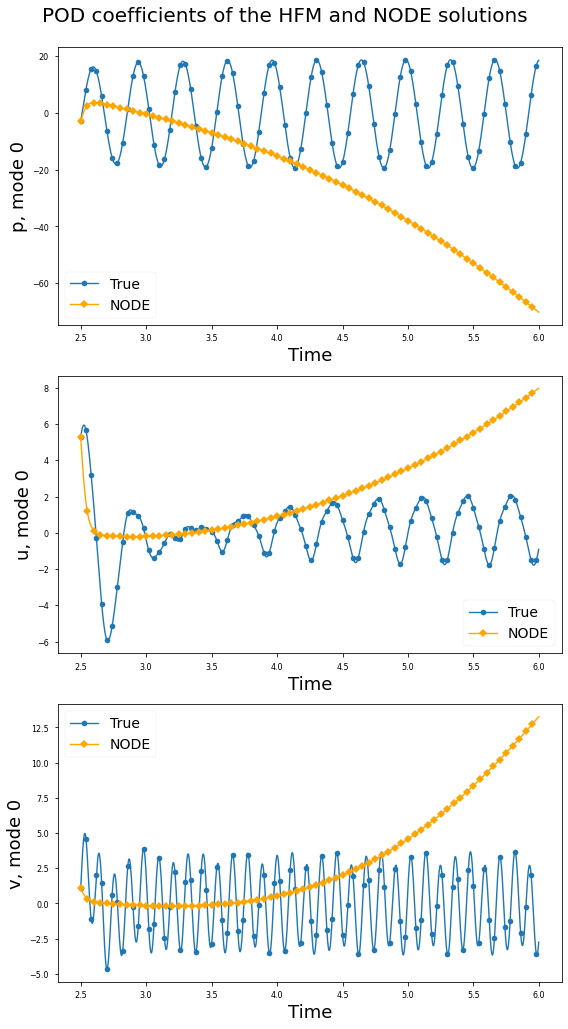

In [12]:
### ----- Visualize true and predicted POD coefficients -------

comp = 0

# Visualization fluff here
fig, ax = plt.subplots(nrows=3,ncols=1,figsize=(8,15))
mnum = comp
for i, key in enumerate(soln_names):
    tt = ax[i].plot(times_predict[:],true_pred_state_array[:,mnum],label='True',marker='o',markevery=20)
    # Visualization of modal evolution using NODE
    ln, = ax[i].plot(times_predict[:],predicted_states[:,mnum],label='NODE',color='orange',marker='D',
                     markevery=25)
    mnum = mnum + nw[key]

    ax[i].set_xlabel('Time', fontsize=18)
    sv = set_label(key)+', mode '+str(comp)
    ax[i].set_ylabel(sv,fontsize=18)
    ax[i].legend(fontsize=14)
fig.suptitle("POD coefficients of the HFM and NODE solutions", fontsize=20)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])

In [13]:
#### ----- Save predicted solutions -------
save_nirom_solutions = False

if save_nirom_solutions:
    os.chdir(nodedir)
    print("Saving results in %s"%(os.getcwd()))

    np.savez_compressed('cylinder_online_node', 
                        p=snap_pred['p'],v_x=snap_pred['v_x'], v_y=snap_pred['v_y'],
                        time=times_predict,loss=train_loss_results)
